In [6]:
###############################################################################
# 
# author: Jonathan Fisher
#         j.fisher@fz-juelich.de
#         jonathan.m.fisher@gmail.com
#
# description:
#     generates (obviously fake) simulated biodiff data,
#  with and without slowly varying background. This is used
#  in functional tests of nsxlib.
#
###############################################################################

import numpy as np
import math
import pynsx as nsx
import h5py

pi2 = np.pi / 2.0
wavelength = 2.67
dmin = 1.5
dmax = 50.0
infile = "/home/jonathan/git/nsxtool/tests/data/blank.hdf"
outfile = "/home/jonathan/git/nsxtool/tests/data/simulated.hdf"

group_name = "P 21 21 21"
#group_name = "P 1"
group = nsx.SpaceGroup(group_name)

from matplotlib import pyplot as plt

def correct_image(image):
    baseline = 227.0
    gain = 8.0
    return gain*(image+baseline)

def poisson_noise(image):
    return np.sqrt(image)*np.random.normal(0, 1, image.shape)

exp = nsx.Experiment("Simulated", "BioDiff2500")
diff = exp.diffractometer()
reader = nsx.HDF5DataReader(infile, diff)
data = nsx.DataSet(reader)
exp.addData(data)

A = np.diag([43., 53., 61.])
U = np.random.rand(3,3)
U = np.identity(3) + U.dot(U.transpose())
_, U = np.linalg.eig(U)

uc = nsx.UnitCell(U.dot(A))
ch = nsx.CellCharacter(uc.metric())
print(ch.a, ch.b, ch.c)
uc.niggliBasis()

uc.setSpaceGroup(group_name)

det_shape = nsx.Ellipsoid(np.array([800.0, 450.0, 10.0]), 5.0)
peak = nsx.Peak3D(data, det_shape)
peak.setSelected(True)

hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)
len(hkls)

42.99999999999999 53.0 61.00000000000001


172542

In [7]:
print(data.nFrames())

166


In [8]:
qs = nsx.ReciprocalVectorList()
B = uc.reciprocalBasis()

for hkl in hkls:
    q = hkl.rowVector().dot(B)
    qs.push_back(nsx.ReciprocalVector(q))

In [9]:
events = data.getEvents(qs)
len(events)

27808

In [10]:
sigmaD = 0.3
sigmaM = 0.2

peaks = []

for event in events:
    center = np.array([event._px, event._py, event._frame])
    peak = nsx.Peak3D(data, nsx.Ellipsoid(center, 5.0))
    coords = nsx.PeakCoordinateSystem(peak)
    shape = coords.detectorShape(sigmaD, sigmaM)
    peak.setShape(shape)
    peaks.append(peak)

In [11]:
A = np.random.rand(3,3)
A /= np.linalg.norm(A)
A = 0.5*np.identity(3) + A.dot(A.transpose())
A /= np.linalg.norm(A)
A *= 50


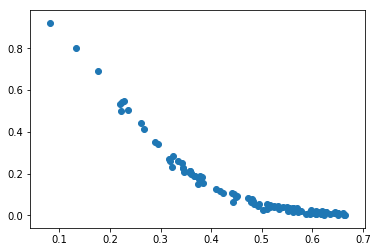

In [12]:
import random
from matplotlib import pyplot as plt

qs = []
Is = []

for i in range(100):
    peak = random.sample(peaks, 1)[0]
    q = peak.q().rowVector()
    qs.append(np.linalg.norm(q))
    
    new_I = 0
    
    elements = group.groupElements()
    for el in elements:
        g = el.getRotationPart()
        gq = q.dot(g)
        new_I += np.exp(-gq.dot(A).dot(gq.transpose()).trace() / 2.0)
        
    I = new_I / len(elements)    
    Is.append(I)
    #print(I)
       
        
plt.scatter(qs, Is)
plt.show()

In [13]:
np.linalg.eig(A)

(array([43.44429845, 19.03458943, 15.82015606]),
 array([[-0.53623033, -0.64694227,  0.54214641],
        [-0.73202425,  0.03665855, -0.68029159],
        [-0.42023508,  0.76165731,  0.49323486]]))

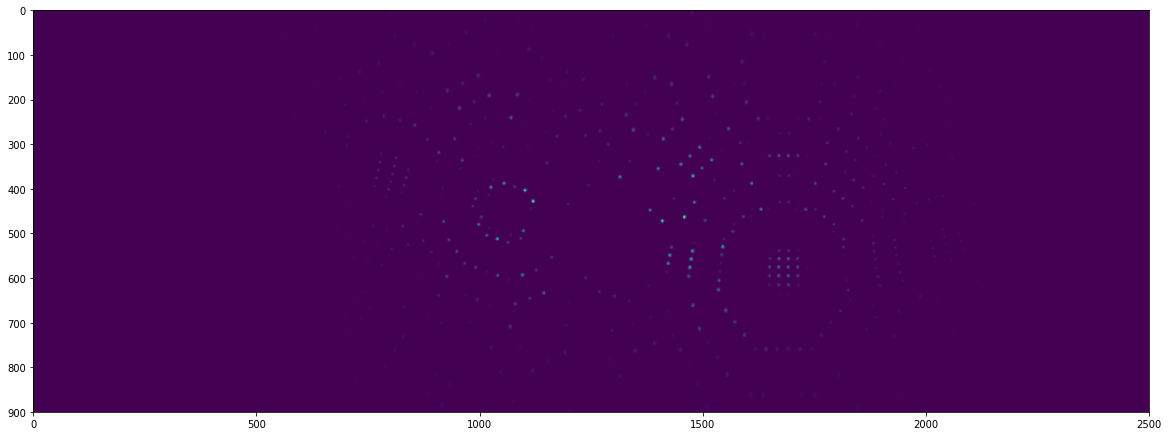

In [15]:
def frame_peaks(idx, peaks, nsigma):
    in_frame = []
    
    for peak in peaks:
        center = peak.getShape().center()
        extents = peak.getShape().aabb().extents()
        
        df = extents[2] / 2.0
        
        if abs(center[2]-idx) > nsigma*df:
            continue
            
        in_frame.append(peak)
        
    return in_frame

def generate_frames(peaks, fmin, fmax):
    Imax = 200**2
    nsigma = 4    
    rows, cols = data.frame(0).shape
    image = np.zeros(shape=(rows, cols, fmax-fmin), dtype=np.float)
    
    B = uc.reciprocalBasis()
    BI = np.linalg.inv(B)
       
    #in_frame = frame_peaks(idx, peaks, nsigma)
    #print(len(in_frame))
    elements = group.groupElements()
    gs = [ B.dot(el.getRotationPart()).dot(BI) for el in elements ]
    
    for peak in peaks:
        #print("#######################################")
        
        
        aabb = peak.getShape().aabb()
        shape = peak.getShape()
        center = shape.center()
        inv_cov = shape.metric()
        extents = aabb.extents()
        
        I = 0        
        q = peak.q().rowVector().transpose()        
        
        for g in gs:
            gq = g.dot(q)
            I += Imax * np.exp(-0.5*gq.transpose().dot(A).dot(gq).trace())
            
        I /= len(gs)
        #print("intensity", I)
        
        xmin = int(center[0,0] - nsigma*extents[0,0]/2)
        xmax = int(center[0,0] + nsigma*extents[0,0]/2)
        
        ymin = int(center[1,0] - nsigma*extents[1,0]/2)
        ymax = int(center[1,0] + nsigma*extents[1,0]/2)
        
        zmin = int(center[2,0] - nsigma*extents[2,0]/2)
        zmax = int(center[2,0] + nsigma*extents[2,0]/2)
        
        xmin = max(0, xmin)
        xmax = min(data.nCols(), xmax)
        
        ymin = max(0, ymin)
        ymax = min(data.nRows(), ymax)
        
        #print("z0", zmin, zmax)
        
        zmin = max(fmin, zmin)
        zmax = min(fmax, zmax)
        
        #print("x", xmin, xmax)
        #print("y", ymin, ymax)
        #print("z", zmin, zmax)       
        
        x = range(xmin, xmax)
        y = range(ymin, ymax)
        z = range(zmin, zmax)
        
        if xmin >= xmax or ymin >= ymax or zmin >= zmax:
            continue
               
        #print("x:", x)
        #print("y:", y)
        
        #print("dx:", np.array(x)-center[0,0])
        #print("dy:", np.array(y)-center[1,0])
        
        x, y, z = np.meshgrid(x, y, z)
                
        dx = x-center[0,0]
        dy = y-center[1,0]
        dz = z-center[2,0]
        
        
        #print("dx", dx.transpose())
        
        M = shape.metric()
        #print(M.shape)
        #print(dx.shape)
        #print(x.shape)
        arg = dx**2 * M[0,0] + dy**2 * M[1,1] + dz**2 * M[2,2]
        arg += 2*dx*dy*M[0,1] + 2*dx*dz*M[0,2] + 2*dy*dz*M[1,2]
               
        gauss = np.exp(-0.5*arg)
        gauss /= gauss.sum()
        
        inten = I * gauss
        #print("inten", inten.shape)
        #print("im", image.shape, image[ymin:ymax, xmin:xmax, (zmin-fmin):(zmax-fmin)].shape)
        #print("integrated intensity", inten.sum())
        #print("z", zmin, zmax)
        image[ymin:ymax, xmin:xmax, (zmin-fmin):(zmax-fmin)] += inten   
        
        
        
        #break
    
    return image

im = generate_frames(peaks, 45, 55)
plt.figure(figsize=(20,10))
plt.imshow(im[:, :, 5])
plt.show()

In [16]:
for el in group.groupElements():
    print(el.getRotationPart())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]


In [18]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())
param = nsx.IndexerParameters()

for peak in peaks:
    indexer.addPeak(peak)
    
indexer.autoIndex(param)

In [19]:
param = nsx.IndexerParameters()
param.maxdim = 100.0
param.minUnitCellVolume = 20*20*20
#param.nVertices = 1000

In [20]:
solns = indexer.getSolutions()

for sln in solns:
    fit_uc, score = sln
    ch = nsx.CellCharacter(fit_uc.metric())
    print(ch.a, ch.b, ch.c, score)

42.999999999999076 53.00000000000025 60.99999999999967 100.0
80.80841540361514 101.01980003915186 129.63795740421307 100.0
139.4632568098135 60.99999999999995 180.76780686836906 100.0
129.63795740446113 149.50919704153935 152.22023518573874 100.0
180.7678068683691 60.99999999999999 263.38754716197195 100.0
180.7678068683689 60.9999999999999 267.4060582709369 100.0
180.7678068683691 60.999999999999986 278.92651361962686 100.0
136.49908424601244 60.999999999999964 369.8499695822619 100.0
105.43718509140818 149.50919704151752 257.2275257432661 100.0
202.03960007879635 60.99999999999995 315.92562415859845 100.0
139.46325680981346 60.99999999999998 475.3956247169299 100.0
180.76780686836906 60.999999999999964 378.9683364082017 100.0
164.71186963907607 60.99999999999999 539.9416635156056 100.0
315.9256241585986 61.0 333.9281359813814 100.0
298.52973051272454 105.99999999999967 251.1433853399282 100.0
361.5356137367382 60.99999999999996 378.96833640820165 100.0
318.00000000000017 60.999999999

In [21]:
COB = np.linalg.inv(solns[3][0].basis()).dot(uc.basis())
print(COB)
1.0 / np.linalg.det(COB)

[[-0.05263158 -0.26315789  0.42105263]
 [-0.15789474  0.21052632  0.26315789]
 [ 0.21052632  0.05263158  0.31578947]]


-19.00000000000473

In [22]:
print(solns[0][0].niggliBasis())
print(solns[0][0].basis())

[[-30.0511449  -35.88037471 -14.07981417]
 [-27.67141304  39.0075812  -12.82394303]
 [-13.42466351  -0.08555536  57.95088712]]
[[-30.0511449  -35.88037471 -14.07981417]
 [-27.67141304  39.0075812  -12.82394303]
 [-13.42466351  -0.08555536  57.95088712]]


In [23]:
im.mean()

0.7410670040623855

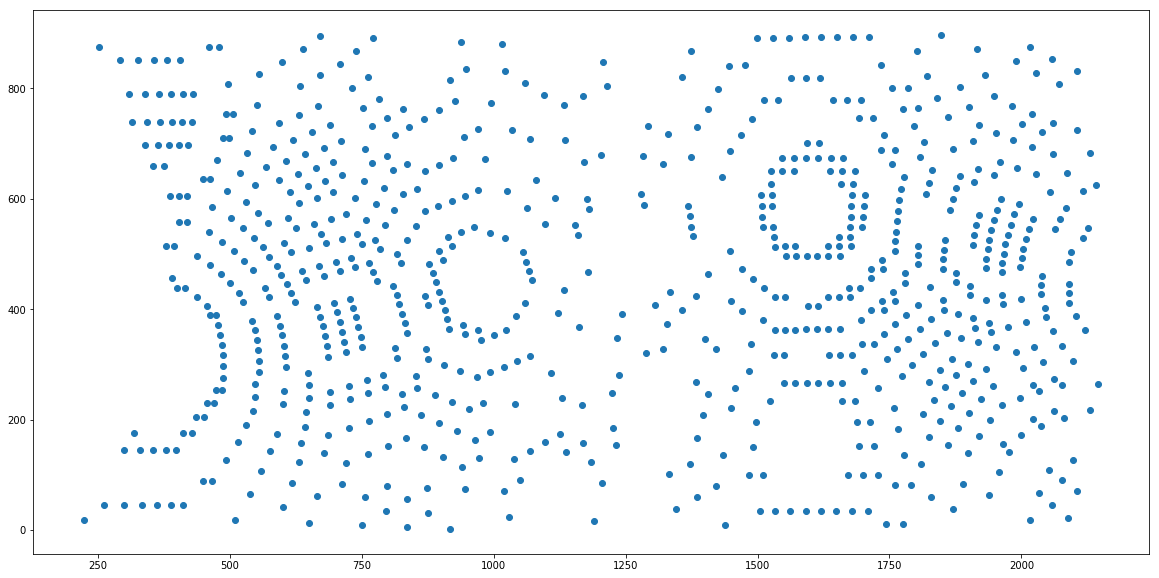

In [24]:
in_frame = frame_peaks(10, peaks, 3)

xs = []
ys = []

for peak in in_frame:
    c = peak.getShape().center()
    xs.append(c[0,0])
    ys.append(c[1,0])

plt.figure(figsize=(20,10))
plt.scatter(xs, ys)
plt.show()

In [27]:
def background():
    return 40.0

In [28]:
#N = data.nFrames()
N = 5
delta = 0.3 # hard coded!!

with h5py.File(outfile, "w") as f:
    data_grp = f.create_group("Data")
    scan = f.create_group("Data/Scan")
    expr = f.create_group("Experiment")
    info = f.create_group("Info")
    
    images = data_grp.create_dataset("Counts", (N, 900, 2500,), dtype='i4', compression="gzip", compression_opts=9)
    
    scan.create_dataset("Sample/chi", (N,), dtype="f8")
    omega = scan.create_dataset("Sample/omega", (N,), dtype="f8")
    scan.create_dataset("Sample/phi", (N,), dtype="f8")
    
    scan.create_dataset("Source/chi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/om-mono", (N,), dtype="f8")
    scan.create_dataset("Source/phi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/x-mono", (N,), dtype="f8")
    scan.create_dataset("Source/y-mono", (N,), dtype="f8")
    
    scan.create_dataset("Detector/2theta(gamma)", (N,), dtype="f8")
    
    expr.attrs.create("npdone", N, dtype="i4")
    expr.attrs.create("monitor", 0.0)
    expr.attrs.create("wavelength", 2.67)
    expr.attrs.create("Numor", 0, dtype="i4")
  
    info.attrs.create("Instrument", b"BioDiff2500")
    
       
    bkg = background()
    simulated = generate_frames(peaks, 0, N)
        
    for i in range(N):        
    #for i in range(10):        
        #simulated = generate_frame(i, peaks) + bkg
        sim = simulated[:, :, i]
        noise = poisson_noise(sim)        
        sim += noise
        sim = correct_image(sim)
        images[i] = sim
        omega[i] = i*delta
        
        print(i, images[i].mean())
        
            
    f.flush()
    f.close()
    
print("Done simulating data.")

0 1818.0316688888888
1 1819.7948302222221
2 1820.1344577777777
3 1820.5681337777778
4 1832.9186577777778
Done simulating data.


In [29]:
simulated = generate_frames(peaks, 0, N)

In [30]:
simulated.shape

(900, 2500, 5)

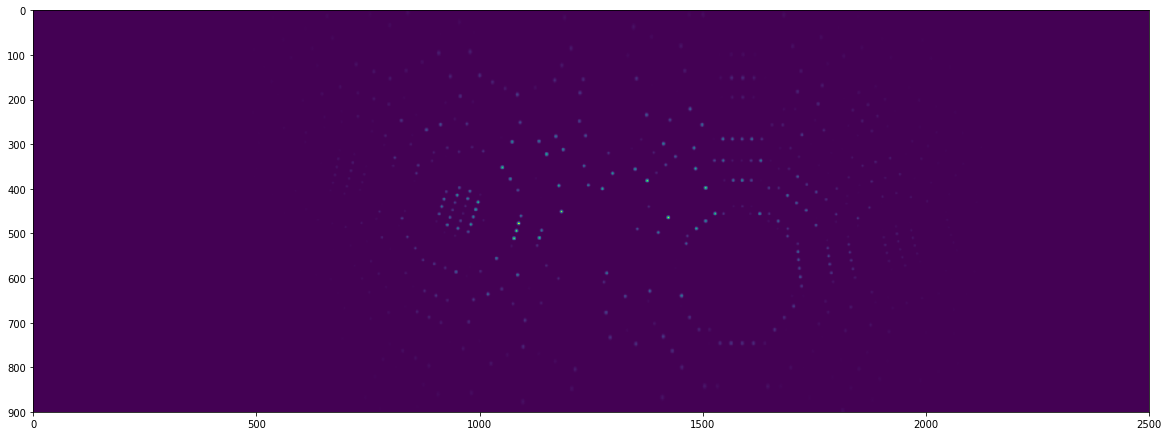

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(simulated[:,:,2])
plt.show()